In [1]:

try:
    del range
except:
    pass

import requests
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
saat=datetime.now().hour
import cloudscraper
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor,as_completed
simdi = datetime.now()
saat1 = simdi.hour
dakika = simdi.minute
import time
tarih=pd.read_csv("tarih.csv")
tarih=pd.to_datetime(tarih.iloc[0,0])


# Döngü çalışabilir durumda
print("Döngü başladı, saat:", simdi.strftime("%H:%M:%S"))

            

bugün=datetime.now().strftime("%Y-%m-%d")



dün=(datetime.now()-timedelta(days=1)).strftime("%Y-%m-%d")


data=pd.read_csv("sepet.csv",index_col=0)
data=data.rename(columns={"Ürün Adı":"Ürün"})

data.index.name=""

try:
    data=data.drop(f"{bugün}",axis=1)
except:
    pass





def veriekle(ürün, data, urunler_df):
    if urunler_df is None or urunler_df.empty:
        return data
    else:

        if isinstance(data.loc[ürün], pd.Series):
                urun_data=pd.DataFrame(data.loc[ürün]).T
                urun_data = pd.merge(
                    urun_data, 
                    urunler_df, 
                    on='Ürün', 
                    how='outer'
                )
            
            # Çakışan sütunları birleştir
                if f'{bugün}_x' in urun_data.columns and f'{bugün}_x' in urun_data.columns:
                    urun_data[f'{bugün}'] = urun_data[f'{bugün}_x'].combine_first(urun_data[f'{bugün}_y'])
                    urun_data.drop([f'{bugün}_x', f'{bugün}_y'], axis=1, inplace=True)
                
                # İndeksi düzenle
                    urun_data = urun_data.set_index([[ürün] * len(urun_data)])
                    
                    # Mevcut ürünü veri setinden kaldır
                    data = data.drop(ürün, axis=0)
                    
                    # Yeni veriyi ekle
                    data = pd.concat([data, urun_data], axis=0)
            
            
        else:
            
            urun_data = data.loc[ürün]
            
            # Merge işlemi sırasında sütun çakışması yaşanırsa, önekler oluşur
            urun_data = pd.merge(
                urun_data, 
                urunler_df, 
                on='Ürün', 
                how='outer'
            )
            
            # Çakışan sütunları birleştir
            if f'{bugün}_x' in urun_data.columns and f'{bugün}_x' in urun_data.columns:
                urun_data[f'{bugün}'] = urun_data[f'{bugün}_x'].combine_first(urun_data[f'{bugün}_y'])
                urun_data.drop([f'{bugün}_x', f'{bugün}_y'], axis=1, inplace=True)
            
            # İndeksi düzenle
            urun_data = urun_data.set_index([[ürün] * len(urun_data)])
            
            # Mevcut ürünü veri setinden kaldır
            data = data.drop(ürün, axis=0)
            
            # Yeni veriyi ekle
            data = pd.concat([data, urun_data], axis=0)

        return data
            
            







import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager






import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

def scrape_sok(urls):
    df=[]
    for url in urls:

        response = requests.get(url)

        # Sayfa başarılı şekilde alındıysa
        if response.status_code == 200:
            # Sayfanın HTML içeriğini parse ediyoruz
            soup = BeautifulSoup(response.text, 'html.parser')

            # Ürünleri seçiyoruz, her bir ürün div'ini tanımlıyoruz
            products = soup.find_all('div', class_='CProductCard-module_productCardWrapper__okAmT')

            # Ürünleri listeleyelim
            for product in products:
                # Ürün adı
                name = product.find('h2', class_='CProductCard-module_title__u8bMW').text.strip()
                
                # Ürün fiyatı
                price = product.find('span', class_='CPriceBox-module_price__bYk-c')
                discounted_price = product.find('span', class_='CPriceBox-module_discountedPrice__15Ffw')
                if not price:
                    price = discounted_price
                if price and discounted_price:
                    price=discounted_price
                price=price.text.strip()
                price=price.replace("₺","").replace(".","").replace(",",".")
                price=float(price)
                
            
                print(f"Ürün Adı: {name}")
                print(f"Fiyat: {price}")
                print("-" * 40)
                df.append({"Product Name":name,"Price (TRY)":price})
                

        else:
            print("Sayfa alınamadı, hata kodu:", response.status_code)
        df=pd.DataFrame(df)
        return df






def clean_price(price_text):
    price_text = price_text.replace("TL", "").strip()  # "TL" ibaresini kaldır
    price_text = price_text.replace(",", ".")  # Türkçe ondalık formatı düzelt
    try:
        return float(price_text)
    except ValueError:
        return None
def scrape_migros_products(pages):
    urunad = []
    urunfiyat = []

    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "application/json, text/plain, */*"
    }

    scraper = cloudscraper.CloudScraper()

    def sayfa_sayisi(url):
        return scraper.get(url, headers=headers).json()["data"]["searchInfo"]["pageCount"]

    def sayfa_verisini_cek(url, sayfa):
        response = scraper.get(f"{url}?page={sayfa}", headers=headers).json()
        return response["data"]["searchInfo"]["storeProductInfos"]

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for i in pages:
            try:
                sayfa_sayisi_val = sayfa_sayisi(i)
                for j in range(1, sayfa_sayisi_val + 1):
                    futures.append(executor.submit(sayfa_verisini_cek, i, j))
            except Exception as e:
                print(f"⚠️ Sayfa sayısı belirlenirken hata oluştu: {e}")

        for future in as_completed(futures):
            try:
                info = future.result()
                for urun in info:
                    urunad.append(urun.get("name"))
                    urunfiyat.append(int(urun.get("salePrice")) / 100)
            except Exception as e:
                print(f"⚠️ Sayfa verisi çekerken hata oluştu: {e}")

    veri = pd.DataFrame({"Product Name": urunad, "Price (TRY)": urunfiyat})
    print("✅ Migros verisi çekildi!")
    return veri

def scrape_carrefour_products(pages):
    print("🔍 Carrefour verisi çekiliyor...")

    options = Options()
    options.add_argument("--headless")  # Başsız mod
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")  # User-Agent
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    carrefour_data = []

    for url in pages:
        print(f"📌 Scraping URL: {url}")
        driver.get(url)

        try:
            # **Sayfanın tamamen yüklenmesini bekle**
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "li.product-listing-item"))
            )

            # **📌 Sayfanın sonuna kadar kaydırarak tüm ürünleri yükle**
            last_height = driver.execute_script("return document.body.scrollHeight")
            while True:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(3)  # Sayfanın yüklenmesini bekle
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:  # Daha fazla ürün yüklenmiyorsa çık
                    break
                last_height = new_height

            # **📌 Ürünleri bul**
            products = driver.find_elements(By.CSS_SELECTOR, "li.product-listing-item")
            print(f"✅ Toplam Ürün Sayısı: {len(products)}")

            for product in products:
                try:
                    # **Ürün adı**
                    try:
                        name_element = product.find_element(By.CSS_SELECTOR, "h3.item-name")
                        product_name = name_element.text.strip()
                    except:
                        pass
                    # **Fiyatı al**
                    try:
                        price_element = product.find_element(By.CSS_SELECTOR, "span.priceLineThrough.js-variant-price")
                        product_price_text = price_element.text.strip()
                    except:
                        try:
                            price_element = product.find_element(By.CSS_SELECTOR, "span.item-price.js-variant-discounted-price")
                            product_price_text = price_element.text.strip()
                        except:
                            pass

                    product_price = clean_price(product_price_text)

                    if product_name and product_price is not None:
                        carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                        print(f"✅ Collected - Product: {product_name}, Price: {product_price} TRY")

                except Exception as e:
                    print(f"⚠️ Hata oluştu: {e}")

        except Exception as e:
            print(f"❌ Timeout veya başka hata oluştu: {e}")

        

    driver.quit()
    return carrefour_data

# 📌 Ana Fonksiyon
def vericek(carrefour, migros,sok, name):
    
    print(f"{name} verisi çekiliyor...")
    bugün = time.strftime("%Y-%m-%d")  # Bugünün tarihini al

    migros_data = scrape_migros_products(migros)
    sok_data=scrape_sok(sok)
    

    try:
        if carrefour:
            
            carrefour_data = scrape_carrefour_products(carrefour)
            
        carrefour_data = pd.DataFrame(carrefour_data)
        

        all_data = pd.concat([migros_data, carrefour_data,sok_data], axis=0)
    except Exception as e:
        print(f"⚠️ Carrefour verisi çekilirken hata oluştu: {e}")
        all_data = all_data = pd.concat([migros_data,sok_data], axis=0)

    if all_data.empty:
        return pd.DataFrame()

    product_df = all_data.copy()
    product_df['Product Group'] = product_df['Product Name'].str.lower()

    # Geometrik ortalama hesaplama fonksiyonu
    def geometric_mean(prices):
        return np.exp(np.mean(np.log(prices)))

    geo_mean_df = (
        product_df.groupby(['Product Group'])
        .agg(
            Geometric_Mean=('Price (TRY)', geometric_mean),
            Product_Names=('Product Name', lambda x: ', '.join(x))
        )
        .reset_index()
    )

    geo_mean_df = geo_mean_df.drop("Product Group", axis=1)
    geo_mean_df.columns = ["Price (TRY)", "Product Name"]

    urunler_df = geo_mean_df.copy()
    if not urunler_df.empty:
        urunler_df.columns = [str(bugün), "Ürün"]
        urunler_df.index = len(urunler_df) * [name]
        urunler_df = urunler_df.drop_duplicates().dropna()
        return urunler_df

    try:
        all_data.columns = ["Ürün", str(bugün)]
        return all_data
    except:
        return pd.DataFrame()

carrefour = ["https://www.carrefoursa.com/pirinc/c/1134?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pirinc-c-427"
]
sok=["https://www.sokmarket.com.tr/pirinc-ve-bulgur-c-1810"]



urunler_df=vericek(carrefour,migros_pages,sok,"Pirinç")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pirinç",case=False)]

data=veriekle("Pirinç",data,urunler_df)
    






pages1 = ["https://www.carrefoursa.com/bugday-unu/c/1277?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]

    



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sade-un-c-289b"]

sok=["https://www.sokmarket.com.tr/un-c-1782"]
urunler_df=vericek(pages1,migros_pages,sok,"Buğday Unu")






data=veriekle("Buğday Unu",data,urunler_df)









pages1=["https://www.carrefoursa.com/bebek-mamasi/c/1848?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
    




migros_pages =["https://www.migros.com.tr/rest/search/screens/devam-sutu-c-1136b"]
sok=["https://www.sokmarket.com.tr/bebek-mama-c-20638"]

urunler_df=vericek(pages1,migros_pages,sok,"Bebek Sütü (Toz Karışım)")



data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)








pages1 = ["https://www.carrefoursa.com/bulgur/c/1142?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
    




# Define base URL and total pages to scrape for Migros
migros_pages1= ["https://www.migros.com.tr/rest/search/screens/pilavlik-bulgur-c-2785"]
sok=["https://www.sokmarket.com.tr/pirinc-ve-bulgur-c-1810"]


urunler_df=vericek(pages1,migros_pages1,sok,"Bulgur")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bulgur",case=False)]

data=veriekle("Bulgur",data,urunler_df)





pages1 = ["https://www.migros.com.tr/rest/search/screens/ekmek-c-455"]
carrefour=["https://www.carrefoursa.com/ekmek/c/2378?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
sok=["https://www.sokmarket.com.tr/ekmek-c-1240"]    




urunler_df=vericek(carrefour,pages1,sok,"Ekmek")

urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ekmek",case=False)]

data=veriekle("Ekmek",data,urunler_df)






pages1 = ["https://www.carrefoursa.com/biskuvi/c/1529?q=%3AbestSeller%3Acategory%3A1534%3Acategory%3A1533%3Acategory%3A1537%3Acategory%3A1530%3Acategory%3A1531%3Acategory%3A1536%3AinStockFlag%3Atrue&show=All"]

    
migros=["https://www.migros.com.tr/rest/search/screens/biskuvi-c-43c"]
sok=["https://www.sokmarket.com.tr/biskuvi-c-20378?page=1","https://www.sokmarket.com.tr/biskuvi-c-20378?page=2","https://www.sokmarket.com.tr/biskuvi-c-20378?page=3",
        "https://www.sokmarket.com.tr/biskuvi-c-20378?page=4","https://www.sokmarket.com.tr/biskuvi-c-20378?page=5"]
urunler_df=vericek(pages1,migros,sok,"Bisküvi")




data=veriekle("Bisküvi",data,urunler_df)





pages1= ["https://www.carrefoursa.com/kraker/c/1538?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]









# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/kraker-c-27ea"]

sok=["https://www.sokmarket.com.tr/kraker-ve-tuzlu-biskuvi-c-20380"]

urunler_df=vericek(pages1,migros_pages,sok,"Kraker")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kraker", case=False)]






data=veriekle("Kraker",data,urunler_df)





pages1= ["https://www.carrefoursa.com/bar-ve-gofret/c/1505?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]

migros=["https://www.migros.com.tr/rest/search/screens/gofret-c-43a"]
sok=["https://www.sokmarket.com.tr/gofret-c-20379?page=3","https://www.sokmarket.com.tr/gofret-c-20379?page=2","https://www.sokmarket.com.tr/gofret-c-20379?page=1"]
urunler_df=vericek(pages1,migros,sok,"Gofret")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Gofret|gofret", regex=True)]


data=veriekle("Gofret",data,urunler_df)









pages1= ["https://www.carrefoursa.com/pastalar/c/1289?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pasta-c-459"]
sok=["https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-54427"]
urunler_df=vericek(pages1,migros_pages,sok,"Pasta")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("pasta", case=False)]

data=veriekle("Pasta",data,urunler_df)








pages1= ["https://www.carrefoursa.com/mini-kek/c/1547?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/kek-c-43d"]
sok=["https://www.sokmarket.com.tr/kek-c-20381?page=3","https://www.sokmarket.com.tr/kek-c-20381?page=2","https://www.sokmarket.com.tr/kek-c-20381?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Kek")


data=veriekle("Kek",data,urunler_df)









pages1= ["https://www.carrefoursa.com/serbetli-tatli/c/1294?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]




migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pastane-tatlilar-c-287b"
]
sok=["https://www.sokmarket.com.tr/sekerleme-c-20388?page=2","https://www.sokmarket.com.tr/sekerleme-c-20388?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Baklava")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Baklava|baklava|Baklavası|baklavası", regex=True)]

    data=veriekle("Baklava",data,urunler_df)




# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/yufka-c-2872"]
sok=["https://www.sokmarket.com.tr/unlu-mamuller-c-29110"]
urunler_df=vericek("",migros_pages,sok,"Ekmek Hamuru (Yufka)")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Yufka", case=False)]


data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)








pages1= ["https://www.carrefoursa.com/makarna/c/1122?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/normal-makarna-c-2780"]
sok=["https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=2","https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Makarna")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Makarna", case=False)]

data=veriekle("Makarna",data,urunler_df)





pages1= ["https://www.carrefoursa.com/makarna/c/1123?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/normal-makarna-c-2780"]
sok=["https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=2","https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Şehriye")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Şehriye|şehriye")]

        data=veriekle("Şehriye",data,urunler_df)







pages1= ["https://www.carrefoursa.com/kahvaltilik-gevrek/c/1378?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    


# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/misir-gevregi-c-2773"]
sok=["https://www.sokmarket.com.tr/kahvaltilik-gevrek-c-950"]
urunler_df=vericek(pages1,migros_pages,sok,"Müsli ve Hububat Ürünleri")


data=veriekle("Tahıl Gevreği",data,urunler_df)








pages1= ["https://www.carrefoursa.com/dana/c/1046?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/dana-eti-c-3fa"

]
sok=["https://www.sokmarket.com.tr/kirmizi-et-c-170"]
urunler_df=vericek(pages1,migros_pages,sok,"Dana Eti")

data=veriekle("Dana Eti",data,urunler_df)








pages1= ["https://www.carrefoursa.com/kuzu/c/1054?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/kuzu-eti-c-3fb"]


urunler_df=vericek(pages1,migros_pages,"","Kuzu Eti")

data=veriekle("Kuzu Eti",data,urunler_df)









pages1= ["https://www.carrefoursa.com/pilic/c/1061?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/pilic-c-3fe"]
sok=["https://www.sokmarket.com.tr/beyaz-et-c-180"]
urunler_df=vericek(pages1,migros_pages,sok,"Tavuk Eti")




data=veriekle("Tavuk Eti",data,urunler_df)


migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/sakatat-c-3fd"]
sok=["https://www.sokmarket.com.tr/arama?q=kokore%C3%A7"]
urunler_df=vericek("",migros_pages,sok,"Sakatat")


data=veriekle("Sakatat",data,urunler_df)








pages1= ["https://www.carrefoursa.com/sucuk/c/1077?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sucuk-c-404"]

sok=["https://www.sokmarket.com.tr/sucuk-c-200"]

urunler_df=vericek(pages1,migros_pages,sok,"Sucuk")

data=veriekle("Sucuk",data,urunler_df)





    
pages1= ["https://www.carrefoursa.com/sosis/c/1084?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]


migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sosis-c-405"]


sok=["https://www.sokmarket.com.tr/sosis-c-31228"]
urunler_df=vericek(pages1,migros_pages,sok,"Sosis")




data=veriekle("Sosis",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/salam-jambon-ve-fume/c/1092?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/salam-c-112d6"]
sok=["https://www.sokmarket.com.tr/salam-c-31229"]
urunler_df=vericek(pages1,migros_pages,sok,"Salam")



data=veriekle("Salam",data,urunler_df)



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&90=503"]



urunler_df=vericek("",migros_pages,"","Hazır Et Yemekleri")


data=veriekle("Hazır Et Yemekleri",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/baliklar/c/1099?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/mevsim-baliklari-c-402"]

urunler_df=vericek(pages1,migros_pages,"","Balık")

data=veriekle("Balık",data,urunler_df)


    
pages1= ["https://www.carrefoursa.com/paketli-urunler/c/1068?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/konserve-deniz-urunleri-c-285a"]

sok=["https://www.sokmarket.com.tr/balik-konservesi-c-22773"]


urunler_df=vericek(pages1,migros_pages,sok,"Deniz Ürünleri")


data=veriekle("Konserve Balık",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/sut/c/1311?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sut-c-6c"]
sok=["https://www.sokmarket.com.tr/sut-c-470?page=2","https://www.sokmarket.com.tr/sut-c-470?page=1"]


urunler_df=vericek(pages1,migros_pages,sok,"Süt")


data=veriekle("Süt",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/yogurt/c/1389?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/yogurt-c-6e"]

sok=["https://www.sokmarket.com.tr/yogurt-c-480?page=2","https://www.sokmarket.com.tr/yogurt-c-480?page=1"]

urunler_df=vericek(pages1,migros_pages,sok,"Yoğurt")



data=veriekle("Yoğurt",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/sutlu-tatli-puding/c/1962?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/sutlu-tatlilar-c-41c"]
sok=["https://www.sokmarket.com.tr/tatli-ve-puding-c-580"]

urunler_df=vericek(pages1,migros_pages,sok,"Hazır Sütlü Tatlılar")





data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/beyaz-peynir/c/1319?q=%3AbestSeller&show=All"]



    

migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/beyaz-peynir-c-40b"]


sok=["https://www.sokmarket.com.tr/beyaz-peynir-c-500?page=2","https://www.sokmarket.com.tr/beyaz-peynir-c-500?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Beyaz Peynir")





data=veriekle("Beyaz Peynir",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/kasar-/c/1324?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/kasar-peyniri-c-40d"]
sok=["https://www.sokmarket.com.tr/kasar-peynir-c-520"]
urunler_df=vericek(pages1,migros_pages,sok,"Kaşar Peyniri")



data=veriekle("Kaşar Peyniri",data,urunler_df)



pages1= ["https://www.carrefoursa.com/krem-peynir/c/1336?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/krem-peynir-c-2737"]


sok=["https://www.sokmarket.com.tr/krem-peynir-c-510"]

urunler_df=vericek(pages1,migros_pages,sok,"Krem Peynir")



data=veriekle("Krem Peynir",data,urunler_df)








pages1= ["https://www.carrefoursa.com/yumurta/c/1349?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  =   ["https://www.migros.com.tr/rest/search/screens/yumurta-c-70"]

sok=["https://www.sokmarket.com.tr/yumurta-c-190"]

urunler_df=vericek(pages1,migros_pages,sok,"Yumurta")




data=veriekle("Yumurta",data,urunler_df)







pages1= ["https://www.carrefoursa.com/tereyag/c/1350?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/tereyagi-c-413"]

sok=["https://www.sokmarket.com.tr/tereyag-c-31602"]

urunler_df=vericek(pages1,migros_pages,sok,"Tereyağı (Kahvaltılık)")


data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)






    
pages1= ["https://www.carrefoursa.com/margarin/c/1351?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/paket-margarin-c-274e"]

sok=["https://www.sokmarket.com.tr/margarin-c-31727"]


urunler_df=vericek(pages1,migros_pages,sok,"Margarin")


data=veriekle("Margarin",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/zeytinyagi/c/1114?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/zeytinyagi-c-433"]
sok=["https://www.sokmarket.com.tr/sivi-yaglar-c-1780"]
urunler_df=vericek(pages1,migros_pages,sok,"Zeytinyağı")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Zeytinyağı",case=False)]

data=veriekle("Zeytinyağı",data,urunler_df)







pages1= ["https://www.carrefoursa.com/aycicek/c/1112?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/aycicek-yagi-c-42d"]

sok=["https://www.sokmarket.com.tr/sivi-yaglar-c-1780"]


urunler_df=vericek(pages1,migros_pages,sok,"Ayçiçek Yağı")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Zeytinyağı",case=False)]


data=veriekle("Ayçiçek Yağı",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?sayfa=1&93=652"]

sok=["https://www.sokmarket.com.tr/meyve-ve-sebze-c-20?page=2","https://www.sokmarket.com.tr/meyve-ve-sebze-c-20?page=1"]


urunler_df=vericek(pages1,migros_pages,sok,"Portakal")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Portakal|portakal")]



data=veriekle("Portakal",data,urunler_df)




def vericek1(carrefour="",migros="",name=""):
    
    try:

# Function to clean and convert price text to float
        def clean_price(price_text):
            # Remove any non-numeric characters except for commas and dots
            price_text = re.sub(r'[^\d,.]', '', price_text)
            # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
            price_text = price_text.replace(',', '.')
            try:
                return float(price_text)
            except ValueError:
                return None



        # Function to scrape product names and prices from Carrefour for multiple URLs
        def scrape_carrefour_products(pages):
            carrefour_data = []
            
            for url in pages:
                print(f"Scraping URL: {url}")
                driver.get(url)

                try:
                    # Find all product links
                    product_elements = driver.find_elements(By.CSS_SELECTOR, 'a.product-return')

                    for index, product_element in enumerate(product_elements):
                        try:
                            # Extract product name
                            product_name_element = product_element.find_element(By.CSS_SELECTOR, 'h3.item-name')
                            product_name = product_name_element.text.strip()

                            # Extract product price
                            # First, try to find the "priceLineThrough" element for non-discounted price
                            try:
                                price_line_through_element = product_element.find_element(By.CSS_SELECTOR, 'span.priceLineThrough.js-variant-price')
                                price_line_through_text = price_line_through_element.text.strip()
                                product_price = clean_price(price_line_through_text)
                            except:
                                # If no "priceLineThrough", fall back to the current price
                                price_element = product_element.find_element(By.CSS_SELECTOR, 'span.item-price.js-variant-discounted-price')
                                product_price_text = price_element.text.strip()
                                product_price = clean_price(product_price_text)

                            if product_name and product_price is not None:
                                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                                print(f"Collected - Product: {product_name}, Price: {product_price} TRY")
                            else:
                                print(f"Skipping product with incomplete data on {url}")

                        except Exception as e:
                            print(f"Error extracting data from product {index + 1} on {url}: {e}")
                    
                    sleep(2)  # Sleep to mimic human interaction and avoid detection
                
                except Exception as e:
                    print(f"Error while scraping {url}: {e}")

            return carrefour_data


        # Define the list of pages to scrape from Migros
        migros_pages  = migros







        if migros:
            
            
            migros_data = scrape_migros_products(migros)

            
        if carrefour:
            carrefour_data = scrape_carrefour_products(carrefour)

        if migros_data and carrefour:

            all_data = migros_data + carrefour_data
        elif migros_data and not carrefour:
            all_data=migros_data
        else:
            all_data=carrefour_data
        product_df = pd.DataFrame(all_data)

        





        urunler_df = product_df.copy()
        if urunler_df is not None and not urunler_df.empty:
            urunler_df.columns=["Ürün",str(bugün)]
            urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

            urunler_df.index=len(urunler_df)*[name]
            urunler_df=urunler_df.drop_duplicates()
            urunler_df=urunler_df.dropna()

            return urunler_df
    except:
            pass





        

    





carrefour=["https://www.carrefoursa.com/yumusak-meyveler/c/1017?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]

urunler_df=vericek(carrefour,migros,sok,"Üzüm")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Üzüm|üzüm", regex=True)]
        data=veriekle("Üzüm",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?sayfa=1&93=604"]
sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

urunler_df=vericek(carrefour,migros,sok,"Armut")
if urunler_df is not None : 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Armut|armut")]
        data=veriekle("Armut",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?sayfa=1&93=606"]
sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

urunler_df=vericek(carrefour,migros,sok,"Ayva")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayva|ayva")]

        data=veriekle("Ayva",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee?sayfa=1&93=614"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]
urunler_df=vericek(carrefour,migros,sok,name="Çilek")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çilek|çilek")]


data=veriekle("Çilek",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?sayfa=1&93=618"]
sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

urunler_df=vericek(carrefour,migros,sok,"Elma")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Elma|elma")]


        data=veriekle("Elma",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/kavun-ve-karpuz-c-3eb"]

urunler_df=vericek(carrefour,migros,"",name="Karpuz")

if urunler_df is not None: 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Karpuz|karpuz")]


        data=veriekle("Karpuz",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/kavun-ve-karpuz-c-3eb"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]

urunler_df=vericek(carrefour,migros,sok,"Kavun")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kavun|kavun", regex=True)]


        data=veriekle("Kavun",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-meyveler-c-3ea"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]

urunler_df=vericek(carrefour,migros,sok,"Kivi")
if urunler_df is not None :
    if not urunler_df.empty:
            try:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kivisi Kg|Kivisi kg|Kivi Kg|Kivi kg|İBB Hal Kivi|Gold")].loc["Kivi"]


                data=veriekle("Kivi",data,urunler_df)
            except:
                urunler_df=pd.DataFrame(urunler_df).T
                data=veriekle("Kivi",data,urunler_df)
                


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?sayfa=1&93=639"]
sok=["https://www.sokmarket.com.tr/narenciye-c-60"]


urunler_df=vericek(carrefour,migros,sok,"Limon")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Limon|limon", regex=True)]

        data=veriekle("Limon",data,urunler_df)





carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?sayfa=1&93=640"]
sok=["https://www.sokmarket.com.tr/narenciye-c-60"]


urunler_df=vericek(carrefour,migros,sok,"Mandalina")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mandalina Kg|Mandalina KG|Mandalina kg|mandalina kg|mandalina Kg|mandalina KG")]



        data=veriekle("Mandalina",data,urunler_df)




carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-meyveler-c-3ea?sayfa=1&93=645"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]

urunler_df=vericek(carrefour,migros,sok,"Muz")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Muz|muz", regex=True)]
        data=veriekle("Muz",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]
urunler_df=vericek(carrefour,migros,sok,"Şeftali")



data=veriekle("Şeftali",data,urunler_df)
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Şeftali|şeftali")]


        data=veriekle("Şeftali",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?sayfa=1&93=646"]
sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]


urunler_df=vericek(carrefour,migros,sok,"Nar")
if urunler_df is not None:
    if not urunler_df.empty:

        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nar Kg|Nar kg|nar kg|nar Kg|Nar|nar", regex=True)]


        data=veriekle("Nar",data,urunler_df)


carrefour=["https://www.carrefoursa.com/badem/c/1523?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/badem-c-280f?sayfa=1&markalar=6570,425,4373,7923,652"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Badem İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Badem", case=False)]
        
        data=veriekle("Badem İçi",data,urunler_df)


carrefour=["https://www.carrefoursa.com/ceviz/c/1524?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/ceviz-ici-c-2805"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Ceviz İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ceviz", case=False)]

        data=veriekle("Ceviz İçi",data,urunler_df)




carrefour=["https://www.carrefoursa.com/findik/c/1521?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/findik-c-280e"]

sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Fındık İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık", case=False)]

        data=veriekle("Fındık İçi",data,urunler_df)




migros=["https://www.migros.com.tr/rest/search/screens/antep-fistigi-c-280d"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

urunler_df=vericek("",migros,sok,name="Antep Fıstığı")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Antep|antep")]
        data=veriekle("Antep Fıstığı",data,urunler_df)




migros=["https://www.migros.com.tr/rest/search/screens/fistik-c-280c"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

urunler_df=vericek("",migros,sok,name="Yer Fıstığı")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Yer Fıstığı",case=False)]

        data=veriekle("Yer Fıstığı",data,urunler_df)













carrefour=["https://www.carrefoursa.com/leblebi/c/1522?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/leblebi-c-2811"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Leblebi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Leblebi",case=False)]
        data=veriekle("Leblebi",data,urunler_df)






carrefour=["https://www.carrefoursa.com/cekirdek/c/1525?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/aycekirdegi-c-280b"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Ay Çekirdeği")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çekirdek|Çekirdeği",case=False)]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Kabak|kabak")]



        data=veriekle("Ay Çekirdeği",data,urunler_df)


carrefour=["https://www.carrefoursa.com/cekirdek/c/1525?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/kabak-cekirdegi-c-280a"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Kabak Çekirdeği")

if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kabak|kabak")]


        data=veriekle("Kabak Çekirdeği",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=Kuru+%C3%9Cz%C3%BCm%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1519"]
migros=["https://www.migros.com.tr/rest/search/screens/kuru-uzum-c-27fd"]
sok=["https://www.sokmarket.com.tr/kurutulmus-meyve-ve-sebze-c-90"]


urunler_df=vericek("",migros,sok,"Kuru Üzüm")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Üzüm|üzüm")]


        data=veriekle("Kuru Üzüm",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kayisi/c/2492?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/kuru-kayisi-c-2800"]


urunler_df=vericek(carrefour,migros,sok,"Kuru Kayısı")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kayısı|Kayısı")]



        data=veriekle("Kuru Kayısı",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Çarliston Biber")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çarliston|çarliston")]

        data=veriekle("Çarliston Biber",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Dolmalık Biber")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Dolma|Dolmalık")]


        data=veriekle("Dolmalık Biber",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Sivri Biber")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("sivri|Sivri")]

        data=veriekle("Sivri Biber",data,urunler_df)




carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5"]
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]
urunler_df=vericek(carrefour,migros,sok,"Dereotu")
if urunler_df is not None :
    if  not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Dereotu", regex=True)]


        data=veriekle("Dereotu",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=700"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Domates")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Salçası", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Domates|domates", regex=True)]
    

        data=veriekle("Domates",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Taze Fasulye")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fasulye|fasulye")]

        data=veriekle("Taze Fasulye",data,urunler_df)






carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=684"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Havuç")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Havuç|havuç")]

        data=veriekle("Havuç",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=712"]    
sok=["https://www.sokmarket.com.tr/sebze-c-40"]   


urunler_df=vericek(carrefour,migros,sok,"Ispanak")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ispanak|ıspanak")]

        data=veriekle("Ispanak",data,urunler_df)







carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=713"]    
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Kabak")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çekirdeği|Çekirdek|Tatlı")]

        data=veriekle("Kabak",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=668"] 
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Karnabahar")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Karnabahar")]


        data=veriekle("Karnabahar",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=674"] 
sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]

urunler_df=vericek(carrefour,migros,sok,"Kuru Soğan")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("soğan|Soğan")]

        data=veriekle("Kuru Soğan",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=694"] 
carrefour=["https://www.carrefoursa.com/salata-malzemeleri-/c/1027"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,name="Beyaz Lahana")
if urunler_df is not None:
    if not urunler_df.empty:

        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Beyaz Lahana|beyaz lahana|beyaz lahana|Lahana beyaz|Lahana Beyaz")]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Hazır|hazır")]


        data=veriekle("Beyaz Lahana",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=723"] 
carrefour=["https://www.carrefoursa.com/salata-malzemeleri-/c/1027"]


urunler_df=vericek(carrefour,migros,sok,name="Kırmızı Lahana")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kırmızı Lahana|kırmızı lahana|Kırmızı lahana|Lahana Kırmızı|Lahana kırmızı")]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Hazır|hazır")]

        data=veriekle("Kırmızı Lahana",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-sebzeler-c-3f2"] 


urunler_df=vericek(carrefour,migros,sok,"Mantar")


if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mantar|mantar|mantarı|Mantarı")]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çorba|Pano|İstiridye|Salatası")]

        data=veriekle("Mantar",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=724"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


urunler_df=vericek(carrefour,migros,sok,"Kıvırcık")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kıvırcık|Kıvırcık")]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Adet|adet", regex=True)]
        data=veriekle("Kıvırcık",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=733"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


urunler_df=vericek(carrefour,migros,sok,"Maydanoz")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("maydanoz|Maydanoz|maydonoz|Maydonoz")]

        data=veriekle("Maydanoz",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=736"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


urunler_df=vericek(carrefour,migros,sok,"Nane")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nane|nane")]

        data=veriekle("Nane",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=727"] 
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Patlıcan")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Minyatür")]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Patlıcan|patlıcan")]
        data=veriekle("Patlıcan",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=667"] 
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Pırasa")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("pırasa|Pırasa")]

        data=veriekle("Pırasa",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=745"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


urunler_df=vericek(carrefour,migros,sok,"Roka")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("roka|Roka")]
        data=veriekle("Roka",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=708"] 
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Salatalık")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Salatalık|salatalık|hıyar|Hıyar")]

        data=veriekle("Salatalık",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kuru-sarimsak-kg-p-30024962"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=671"] 

sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]
urunler_df=vericek(carrefour,migros,sok,"Sarımsak")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Sarımsak", regex=True)]

        data=veriekle("Sarımsak",data,urunler_df)






migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=740"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]

urunler_df=vericek("",migros,sok,name="Kırmızı Turp")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Turp Kırmızı|Turp kırmızı|Kırmızı Turp|Kırmızı turp|kırmızı turp|turp kırmızı")]
        data=veriekle("Kırmızı Turp",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=678"] 
sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]


urunler_df=vericek(carrefour,migros,sok,"Patates")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Sarımsak|Soğan", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("patates|Patates", regex=True)]
        data=veriekle("Patates",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kuru-fasulye/c/1155?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/fasulye-c-2794"] 
sok=["https://www.sokmarket.com.tr/bakliyat-c-1820"]


urunler_df=vericek(carrefour,migros,sok,"Kuru Fasulye")
if urunler_df is not None : 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("fasulye|Fasulye")]

        data=veriekle("Kuru Fasulye",data,urunler_df)


carrefour=["https://www.carrefoursa.com/nohut/c/1154?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/nohut-c-2798"]
sok=["https://www.sokmarket.com.tr/bakliyat-c-1820"]

urunler_df=vericek(carrefour,migros,sok,"Nohut")
data=veriekle("Nohut",data,urunler_df)
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nohut",case=False)]

        data=veriekle("Nohut",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/mercimek-c-113c9"]



urunler_df=vericek("",migros,sok,"Mercimek")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mercimek",case=False)]
        data=veriekle("Mercimek",data,urunler_df)





carrefour=["https://www.carrefoursa.com/diger-sebze/c/1193?q=%3AbestSeller&show=All","https://www.carrefoursa.com/yesil-sebze/c/1187?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/konserve-sebze-c-2852"]
sok=["https://www.sokmarket.com.tr/konserve-c-1850"]

urunler_df=vericek(carrefour,migros,sok,"Konserveler")
if urunler_df is not None:

    if not urunler_df.empty:
        
        data=veriekle("Konserveler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tursu/c/1234?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/tursu-c-454"]
sok=["https://www.sokmarket.com.tr/tursu-c-1860"]

urunler_df=vericek(carrefour,migros,sok,"Turşu")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Turşu",data,urunler_df)




carrefour=["https://www.carrefoursa.com/salca/c/1180?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/salca-c-453"]
sok=["https://www.sokmarket.com.tr/salca-c-1830"]


urunler_df=vericek(carrefour,migros,sok,"Salça")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Salça",data,urunler_df)


carrefour=["https://www.carrefoursa.com/zeytin/c/1356?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/zeytin-c-71"]
sok=["https://www.sokmarket.com.tr/zeytin-c-900"]


urunler_df=vericek(carrefour,migros,sok,"Zeytin")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Zeytin",data,urunler_df)





carrefour=["https://www.carrefoursa.com/cipsler/c/1552?q=%3AbestSeller%3Acategory%3A1552%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-cipsi-c-27f9"]
sok=["https://www.sokmarket.com.tr/cips-c-20383?page=2","https://www.sokmarket.com.tr/cips-c-20383?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Cipsler")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Cipsler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/toz-seker/c/1162?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/toz-seker-c-544"
]
sok=["https://www.sokmarket.com.tr/mutfak-seker-c-1790"]


urunler_df=vericek(carrefour,migros,sok,"Toz Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Toz", regex=True)]
        data=veriekle("Toz Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kup-seker/c/1161?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/kup-seker-c-543"
]


urunler_df=vericek(carrefour,migros,sok,"Kesme Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Küp|kesme|Kesme", regex=True,case=False)]
        data=veriekle("Kesme Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/recel/c/1367?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/recel-c-277b"
]

sok=["https://www.sokmarket.com.tr/recel-c-910"]
urunler_df=vericek(carrefour,migros,sok,"Reçel")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Reçel",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ballar/c/1362?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/cam-bali-c-2768"
]
sok=["https://www.sokmarket.com.tr/bal-c-920"]

urunler_df=vericek(carrefour,migros,sok,"Bal")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Bal",data,urunler_df)




carrefour=["https://www.carrefoursa.com/pekmez/c/1376?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/pekmez-c-2770"
]
sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]

urunler_df=vericek(carrefour,migros,sok,"Pekmez")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pekmez|Pekmezi", regex=True)]
        data=veriekle("Pekmez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/helva/c/1374?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/helva-c-2771?sayfa=1&markalar=425"
]


urunler_df=vericek(carrefour,migros,sok,"Tahin Helvası")

if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin|tahin", regex=True)]
        data=veriekle("Tahin Helvası",data,urunler_df)




carrefour=["https://www.carrefoursa.com/ezmeler/c/1383?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/findik-ezmesi-c-2778"
]
sok=["https://www.sokmarket.com.tr/krem-cikolata-ve-ezme-c-930"]

urunler_df=vericek(carrefour,migros,sok,"Fındık Ezmesi")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık Ezmesi", regex=True)]
        data=veriekle("Fındık Ezmesi",data,urunler_df)



carrefour=["https://www.carrefoursa.com/cikolata/c/1507?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/cikolata-c-439"
]

sok=["https://www.sokmarket.com.tr/cikolata-c-20377?page=4","https://www.sokmarket.com.tr/cikolata-c-20377?page=3","https://www.sokmarket.com.tr/cikolata-c-20377?page=2","https://www.sokmarket.com.tr/cikolata-c-20377?page=1"]
urunler_df=vericek(carrefour,migros,sok,"Çikolata Tablet")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tablet|Kare", regex=True)]
        data=veriekle("Çikolata Tablet",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=krem+%C3%A7ikolata%3AbestSeller%3AproductPrimaryCategoryCode%3A1381%3AinStockFlag%3Atrue&text=krem+%C3%A7ikolata#"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-findik-kremalari-c-2779"
]


urunler_df=vericek("",migros,sok,"Çikolata Krem")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Ezmesi", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Krem|krem", regex=True,case=False)]
        data=veriekle("Çikolata Krem",data,urunler_df)



carrefour=["https://www.carrefoursa.com/lokum/c/2397?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/lokum-c-281c"
]
sok=["https://www.sokmarket.com.tr/arama?q=lokum&kategori=20376"]

urunler_df=vericek(carrefour,migros,sok,"Lokum")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Lokum|lokum", regex=True)]
        data=veriekle("Lokum",data,urunler_df)






carrefour=["https://www.carrefoursa.com/sakizlar/c/1501?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/sakiz-c-443"
]
sok=["https://www.sokmarket.com.tr/sakiz-c-20387?page=2","https://www.sokmarket.com.tr/sakiz-c-20387?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Sakız")
if urunler_df is not None :
    if not urunler_df.empty:
        data=veriekle("Sakız",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sekerleme/c/1494?q=%3AbestSeller%3Acategory%3ABRN-1949%3Acategory%3ABRN-2504%3Acategory%3ABRN-3185%3Acategory%3ABRN-2125%3Acategory%3ABRN-3091%3Acategory%3ABRN-2999%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/geleneksel-sekerleme-c-2819"
]
sok=["https://www.sokmarket.com.tr/sekerleme-c-20388?page=2","https://www.sokmarket.com.tr/sekerleme-c-20388?page=2"]


urunler_df=vericek(carrefour,migros,sok,"Kağıtlı Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Baklava|Pişmaniye|Lokum", case=False)]
        data=veriekle("Kağıtlı Şeker",data,urunler_df)




carrefour=["https://www.carrefoursa.com/kap-dondurma/c/1261?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All",
        "https://www.carrefoursa.com/tek-dondurma/c/1266?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/dondurma-c-41b"
]
sok=["https://www.sokmarket.com.tr/dondurma-c-31102?page=3","https://www.sokmarket.com.tr/dondurma-c-31102?page=2","https://www.sokmarket.com.tr/dondurma-c-31102?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Dondurma")

data=veriekle("Dondurma",data,urunler_df)




carrefour=["https://www.carrefoursa.com/baharat/c/1167?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/baharat-c-435"
]
sok=["https://www.sokmarket.com.tr/tuz-baharat-c-1890","https://www.sokmarket.com.tr/tuz-baharat-c-1890?page=2"]



urunler_df=vericek(carrefour,migros,sok,"Baharat")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Baharat",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tuz/c/1166?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/tuz-c-436"
]


urunler_df=vericek(carrefour,migros,sok,"Tuz")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Tuz",data,urunler_df)





carrefour=["https://www.carrefoursa.com/kabartma-tozu/c/1302?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/kabartma-tozu-sekerli-vanilin-c-2893"
]
sok=["https://www.sokmarket.com.tr/arama?q=kabartma"]



urunler_df=vericek(carrefour,migros,sok,"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sirke/c/1217?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/sirke-c-284f"
]
sok=["https://www.sokmarket.com.tr/salata-sosu-c-1900"]


urunler_df=vericek(carrefour,migros,sok,"Sirke")
data=veriekle("Sirke",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ketcap/c/1211?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/ketcap-c-2847"
]
sok=["https://www.sokmarket.com.tr/ketcap-c-31355"]


urunler_df=vericek(carrefour,migros,sok,"Ketçap")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Mayonez", regex=True)]
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ketçap")]

    data=veriekle("Ketçap",data,urunler_df)


carrefour=["https://www.carrefoursa.com/mayonez/c/1212?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/mayonez-c-2848"
]
sok=["https://www.sokmarket.com.tr/mayonez-c-31356"]


urunler_df=vericek(carrefour,migros,sok,"Mayonez")
data=veriekle("Mayonez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tahin-pekmez-helva/c/1374?q=%3AbestSeller%3Acategory%3A1310%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/tahin-c-276f"
]
sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]



urunler_df=vericek(carrefour,migros,sok,"Tahin")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin", regex=True)]
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Pekmezi|Helva", regex=True)]
    data=veriekle("Tahin",data,urunler_df)




carrefour=["https://www.carrefoursa.com/hazir-corbalar/c/1224?q=%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&markalar=424,483"
]
sok=["https://www.sokmarket.com.tr/corba-c-28478"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Çorbalar")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çorba|çorba|çorbası|Çorbası", regex=True)]
        data=veriekle("Hazır Çorbalar",data,urunler_df)





carrefour=["https://www.carrefoursa.com/hazirlanacak-tatlilar/c/1300?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/puding-c-41d"
]
sok=["https://www.sokmarket.com.tr/tatli-ve-puding-c-580"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Pakette Toz Tatlılar (Puding)")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("puding|Puding|pudingi|Pudingi", regex=True)]
        data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)





carrefour=["https://www.carrefoursa.com/turk-kahvesi/c/1468?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#","https://www.carrefoursa.com/filtre-kahve/c/1469?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/filtre-kahve-c-11223","https://www.migros.com.tr/rest/search/screens/turk-kahvesi-c-28c4","https://www.migros.com.tr/rest/search/screens/kapsul-kahve-c-11224","https://www.migros.com.tr/rest/search/screens/cekirdek-kahve-c-11225"
]
sok=["https://www.sokmarket.com.tr/kahve-c-43178?page=2","https://www.sokmarket.com.tr/kahve-c-43178?page=2"]

urunler_df=vericek(carrefour,migros,sok,"Kahve")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Arada|arada", regex=True)]
data=veriekle("Kahve",data,urunler_df)



carrefour=["https://www.carrefoursa.com/granul-kahve/c/1472?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/hazir-kahve-c-11222"
]



urunler_df=vericek(carrefour,migros,sok,"Hazır Kahve")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Türk", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Arada|arada|Starbucks", regex=True)]
        data=veriekle("Hazır Kahve",data,urunler_df)






migros=["https://www.migros.com.tr/rest/search/screens/dokme-cay-c-28c1"
]
sok=["https://www.sokmarket.com.tr/cay-c-960?page=2","https://www.sokmarket.com.tr/cay-c-960?page=1"]

urunler_df=vericek("",migros,sok,name="Çay")
data=veriekle("Çay",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/bitki-cayi-c-28c0"
]


urunler_df=vericek("",migros,sok,name="Bitki ve Meyve Çayı (Poşet)")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bitki", regex=True)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)





migros=["https://www.migros.com.tr/rest/search/screens/uzun-omurlu-sut-c-40a?sayfa=1&109=1005"
]


urunler_df=vericek("",migros,"",name="Kakaolu Toz İçecekler")
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sular/c/1411?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]

migros=["https://www.migros.com.tr/rest/search/screens/su-c-84"
]
sok=["https://www.sokmarket.com.tr/su-c-20506"]
urunler_df=vericek(carrefour,migros,sok,"Su")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Su|su")]
        data=veriekle("Su",data,urunler_df)





carrefour=["https://www.carrefoursa.com/maden-sulari/c/1412?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/maden-suyu-c-85"
]
sok=["https://www.sokmarket.com.tr/maden-suyu-c-20507"]

urunler_df=vericek(carrefour,migros,sok,"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)








carrefour=["https://www.carrefoursa.com/gazoz/c/1423?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/gazoz-c-467"
]
sok=["https://www.sokmarket.com.tr/gazoz-c-20509?page=2","https://www.sokmarket.com.tr/gazoz-c-20509?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)










carrefour=["https://www.carrefoursa.com/kola/c/1419?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/kola-c-465"
]
sok=["https://www.sokmarket.com.tr/kola-c-20508"]


urunler_df=vericek(carrefour,migros,sok,"Kola")
data=veriekle("Kola",data,urunler_df)





carrefour=["https://www.carrefoursa.com/soguk-cay/c/1450?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/soguk-cay-c-28be"]
sok=["https://www.sokmarket.com.tr/soguk-cay-c-31729"]


urunler_df=vericek(carrefour,migros,sok,"Soğuk Çay")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Poşet|Dökme|Çaycı|Yeşil|Gr|gr|Çaykur")]

data=veriekle("Soğuk Çay",data,urunler_df)








carrefour=["https://www.carrefoursa.com/ayran/c/1485?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/ayran-c-47a"
        
]

sok=["https://www.sokmarket.com.tr/ayran-c-31109"]
urunler_df=vericek(carrefour,migros,sok,"Ayran")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayran|ayran", regex=True)]

        data=veriekle("Ayran",data,urunler_df)




carrefour=["https://www.carrefoursa.com/meyve-suyu/c/1430?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/meyve-suyu-c-46c"
        
]
sok=["https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=2","https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)








migros=["https://www.migros.com.tr/rest/search/screens/tulum-peyniri-c-2734"
        
]
sok=["https://www.sokmarket.com.tr/yoresel-peynir-c-530"]


urunler_df=vericek("",migros,sok,name="Tulum Peyniri")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tulum|tulum", regex=True)]
data=veriekle("Tulum Peyniri",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kakao/c/1304?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-c-2894"
        
]
sok=["https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=2","https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=1"]

urunler_df=vericek(carrefour,migros,sok,name="Kakao")
runler_df=urunler_df[urunler_df["Ürün"].str.contains("Kakao|kakao", regex=True)]
data=veriekle("Kakao",data,urunler_df)

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time

# WebDriver Ayarları
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Tarayıcıyı arka planda çalıştırır
driver = webdriver.Chrome(options=options)

# Hedef URL
URL = "https://tarim.ibb.istanbul/avrupa-yakasi-hal-mudurlugu/hal-fiyatlari.html"

# Tarih Aralığı Belirleme
baslangic_tarihi = bugün
bitis_tarihi = bugün

# Tarihleri oluştur
baslangic = datetime.strptime(baslangic_tarihi, "%Y-%m-%d")
bitis = datetime.strptime(bitis_tarihi, "%Y-%m-%d")
gun_sayisi = 1

# Boş DataFrame oluştur
tum_veriler = pd.DataFrame()

try:
    driver.get(URL)
    wait = WebDriverWait(driver, 10)
    
    # "Sebze" kategorisini seç
    kategori_dropdown = wait.until(EC.presence_of_element_located((By.ID, "cbGunlukKategori")))
    select = Select(kategori_dropdown)
    select.select_by_visible_text("Sebze")
    time.sleep(2)  # Kategorinin yüklenmesi için kısa bir bekleme
    try:
        del range
    except:
        pass
    for i in range(gun_sayisi):
        tarih = (baslangic + timedelta(days=i)).strftime("%Y-%m-%d")
        print(f"Veriler çekiliyor (Sebze Kategorisi): {tarih}")
        
        # Tarih alanını bul ve tarih değerini gir
        tarih_input = wait.until(EC.presence_of_element_located((By.ID, "dtGunlukTarih")))
        driver.execute_script("arguments[0].value = arguments[1];", tarih_input, tarih)
        
        # Göster butonuna bas
        goster_button = wait.until(EC.element_to_be_clickable((By.ID, "btnGunlukGoster")))
        goster_button.click()
        
        # Verinin yüklenmesini bekle
        time.sleep(5)  # Statik bir bekleme, optimize edilebilir
        
        # Tabloyu çek
        tablo = wait.until(EC.presence_of_element_located((By.ID, "gunluk_result")))
        df = pd.read_html(tablo.get_attribute("outerHTML"))[0]
        df["Tarih"] = tarih  # Tarih sütunu ekle
        df["Kategori"] = "Sebze"  # Kategori sütunu ekle
        
        tum_veriler = pd.concat([tum_veriler, df], ignore_index=True)

finally:
    driver.quit()

# Veriyi kaydet
from scipy.stats import gmean

tum_veriler.to_excel("hal_fiyatlari_sebze.xlsx", index=False)
print("Veriler 'hal_fiyatlari_sebze.xlsx' dosyasına kaydedildi.")
tum_veriler["En Düşük Fiyat"]=tum_veriler["En Düşük Fiyat"].str.replace(",",".")
tum_veriler["En Düşük Fiyat"]=tum_veriler["En Düşük Fiyat"].str.replace("TL","").astype(float)

tum_veriler["En Yüksek Fiyat"]=tum_veriler["En Yüksek Fiyat"].str.replace(",",".")
tum_veriler["En Yüksek Fiyat"]=tum_veriler["En Yüksek Fiyat"].str.replace("TL","").astype(float)

tum_veriler["Ortalama"]=0.5*tum_veriler["En Düşük Fiyat"]+tum_veriler["En Yüksek Fiyat"]*0.5
tum_veriler=tum_veriler.set_index("Tarih")

sebzeler=pd.DataFrame()
w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")

for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
    
        hal=pd.DataFrame(tum_veriler[tum_veriler["Urun Adı"].str.contains(sebze)]).groupby(level=0)["Ortalama"].apply(gmean,axis=0)
        hal=pd.DataFrame(hal)
        hal=hal.T
        hal["Ürün"]=f"İBB Hal {sebze}"
        hal=hal.reset_index()
        hal.index.name=None
        hal.columns.name = None
        del hal["index"]
        hal.index=[f"{sebze}"]
        sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']


        hal = hal[sira]
        if hal.shape[1]>1:
            print(f"{sebze} verisi bulundu")
            sebzeler=pd.concat([sebzeler,hal],axis=0)
        else:
            print(f"{sebze} verisi yok")


for sebze in sebzeler.index:
    urunler_df=pd.DataFrame(sebzeler.loc[sebze]).T
    data=veriekle(sebze,data,urunler_df)


dolma=tum_veriler[tum_veriler["Urun Adı"].str.contains("Dolma")].groupby(level=0)["Ortalama"].apply(gmean,axis=0)
sebze="Dolmalık Biber"
hal=pd.DataFrame(dolma)
hal=hal.T
hal["Ürün"]=f"İBB Hal {sebze}"
hal=hal.reset_index()
hal.index.name=None
hal.columns.name = None
del hal["index"]
hal.index=[f"{sebze}"]
sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
hal = hal[sira]
data=veriekle(sebze,data,hal)


sivri=tum_veriler[tum_veriler["Urun Adı"].str.contains("Sivri")].groupby(level=0)["Ortalama"].apply(gmean,axis=0)
sebze="Sivri Biber"
hal=pd.DataFrame(sivri)
hal=hal.T
hal["Ürün"]=f"İBB Hal {sebze}"
hal=hal.reset_index()
hal.index.name=None
hal.columns.name = None
del hal["index"]
hal.index=[f"{sebze}"]
sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
hal = hal[sira]
data=veriekle(sebze,data,hal)

fasulye=tum_veriler[tum_veriler["Urun Adı"].str.contains("Çalı")].groupby(level=0)["Ortalama"].apply(gmean,axis=0)
sebze="Taze Fasulye"
hal=pd.DataFrame(fasulye)
hal=hal.T
hal["Ürün"]=f"İBB Hal {sebze}"
hal=hal.reset_index()
hal.index.name=None
hal.columns.name = None
del hal["index"]
hal.index=[f"{sebze}"]
sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
hal = hal[sira]
data=veriekle(sebze,data,hal)

sogan=tum_veriler[tum_veriler["Urun Adı"].str.contains("Soğan Kuru")].groupby(level=0)["Ortalama"].apply(gmean,axis=0)
sebze="Kuru Soğan"
hal=pd.DataFrame(sogan)
hal=hal.T
hal["Ürün"]=f"İBB Hal {sebze}"
hal=hal.reset_index()
hal.index.name=None
hal.columns.name = None
del hal["index"]
hal.index=[f"{sebze}"]
sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
hal = hal[sira]
data=veriekle(sebze,data,hal)

blahana=tum_veriler[(tum_veriler["Urun Adı"].str.contains("Lahana")) & (tum_veriler["Urun Adı"].str.contains("Beyaz"))].groupby(level=0)["Ortalama"].apply(gmean,axis=0)
sebze="Beyaz Lahana"
hal=pd.DataFrame(blahana)
hal=hal.T
hal["Ürün"]=f"İBB Hal {sebze}"
hal=hal.reset_index()
hal.index.name=None
hal.columns.name = None
del hal["index"]
hal.index=[f"{sebze}"]
sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
hal = hal[sira]
data=veriekle(sebze,data,hal)

blahana=tum_veriler[(tum_veriler["Urun Adı"].str.contains("Lahana")) & (tum_veriler["Urun Adı"].str.contains("Kırmızı"))].groupby(level=0)["Ortalama"].apply(gmean,axis=0)
sebze="Kırmızı Lahana"
hal=pd.DataFrame(blahana)
hal=hal.T
hal["Ürün"]=f"İBB Hal {sebze}"
hal=hal.reset_index()
hal.index.name=None
hal.columns.name = None
del hal["index"]
hal.index=[f"{sebze}"]
sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
hal = hal[sira]
data=veriekle(sebze,data,hal)

maydanoz=tum_veriler[tum_veriler["Urun Adı"].str.contains("Maydonoz")].groupby(level=0)["Ortalama"].apply(gmean,axis=0)
sebze="Maydanoz"
hal=pd.DataFrame(maydanoz)
hal=hal.T
hal["Ürün"]=f"İBB Hal {sebze}"
hal=hal.reset_index()
hal.index.name=None
hal.columns.name = None
del hal["index"]
hal.index=[f"{sebze}"]
sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
hal = hal[sira]
data=veriekle(sebze,data,hal)

kturp=tum_veriler[(tum_veriler["Urun Adı"].str.contains("Turp")) & (tum_veriler["Urun Adı"].str.contains("Kırmızı"))].groupby(level=0)["Ortalama"].apply(gmean,axis=0)
sebze="Kırmızı Turp"
hal=pd.DataFrame(kturp)
hal=hal.T
hal["Ürün"]=f"İBB Hal {sebze}"
hal=hal.reset_index()
hal.index.name=None
hal.columns.name = None
del hal["index"]
hal.index=[f"{sebze}"]
sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
hal = hal[sira]
data=veriekle(sebze,data,hal)






from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time

# WebDriver Ayarları
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Tarayıcıyı arka planda çalıştırır
driver = webdriver.Chrome(options=options)

# Hedef URL
URL = "https://tarim.ibb.istanbul/avrupa-yakasi-hal-mudurlugu/hal-fiyatlari.html"

# Tarih Aralığı Belirleme
baslangic_tarihi = bugün
bitis_tarihi = bugün

# Tarihleri oluştur
baslangic = datetime.strptime(baslangic_tarihi, "%Y-%m-%d")
bitis = datetime.strptime(bitis_tarihi, "%Y-%m-%d")
gun_sayisi = 1

# Boş DataFrame oluştur
tum_veriler = pd.DataFrame()

try:
    driver.get(URL)
    wait = WebDriverWait(driver, 10)
    
    # "Sebze" kategorisini seç
    kategori_dropdown = wait.until(EC.presence_of_element_located((By.ID, "cbGunlukKategori")))
    select = Select(kategori_dropdown)
    select.select_by_visible_text("Meyve")
    time.sleep(2)  # Kategorinin yüklenmesi için kısa bir bekleme
    try:
        del range
    except:
        pass
    for i in range(gun_sayisi):
        tarih = (baslangic + timedelta(days=i)).strftime("%Y-%m-%d")
        print(f"Veriler çekiliyor (Meyve Kategorisi): {tarih}")
        
        # Tarih alanını bul ve tarih değerini gir
        tarih_input = wait.until(EC.presence_of_element_located((By.ID, "dtGunlukTarih")))
        driver.execute_script("arguments[0].value = arguments[1];", tarih_input, tarih)
        
        # Göster butonuna bas
        goster_button = wait.until(EC.element_to_be_clickable((By.ID, "btnGunlukGoster")))
        goster_button.click()
        
        # Verinin yüklenmesini bekle
        time.sleep(5)  # Statik bir bekleme, optimize edilebilir
        
        # Tabloyu çek
        tablo = wait.until(EC.presence_of_element_located((By.ID, "gunluk_result")))
        df = pd.read_html(tablo.get_attribute("outerHTML"))[0]
        df["Tarih"] = tarih  # Tarih sütunu ekle
        df["Kategori"] = "Meyve"  # Kategori sütunu ekle
        
        tum_veriler = pd.concat([tum_veriler, df], ignore_index=True)

finally:
    driver.quit()

# Veriyi kaydet
from scipy.stats import gmean

tum_veriler.to_excel("hal_fiyatlari_sebze.xlsx", index=False)
print("Veriler 'hal_fiyatlari_sebze.xlsx' dosyasına kaydedildi.")
tum_veriler["En Düşük Fiyat"]=tum_veriler["En Düşük Fiyat"].str.replace(",",".")
tum_veriler["En Düşük Fiyat"]=tum_veriler["En Düşük Fiyat"].str.replace("TL","").astype(float)

tum_veriler["En Yüksek Fiyat"]=tum_veriler["En Yüksek Fiyat"].str.replace(",",".")
tum_veriler["En Yüksek Fiyat"]=tum_veriler["En Yüksek Fiyat"].str.replace("TL","").astype(float)

tum_veriler["Ortalama"]=0.5*tum_veriler["En Düşük Fiyat"]+tum_veriler["En Yüksek Fiyat"]*0.5
tum_veriler=tum_veriler.set_index("Tarih")

meyveler=pd.DataFrame()
w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")

for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:
    
        hal=pd.DataFrame(tum_veriler[tum_veriler["Urun Adı"].str.contains(meyve)]).groupby(level=0)["Ortalama"].apply(gmean,axis=0)
        hal=pd.DataFrame(hal)
        hal=hal.T
        hal["Ürün"]=f"İBB Hal {meyve}"
        hal=hal.reset_index()
        hal.index.name=None
        hal.columns.name = None
        del hal["index"]
        hal.index=[f"{meyve}"]
        sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']


        hal = hal[sira]
        if hal.shape[1]>1:
            print(f"{meyve} verisi bulundu")
            meyveler=pd.concat([meyveler,hal],axis=0)
        else:
            print(f"{meyve} verisi yok")


for meyve in meyveler.index:
    urunler_df=pd.DataFrame(meyveler.loc[meyve]).T
    data=veriekle(meyve,data,urunler_df)



import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

category_urls = {

    "https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5":"Antep Fıstığı","https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3":"Ay Çekirdeği","https://www.mopas.com.tr/ayran/c/5.3.2.1":"Ayran","https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1":"Ayçiçek Yağı","https://www.mopas.com.tr/badem/c/4.2.5.8":"Badem İçi","https://www.mopas.com.tr/baharat/c/4.11.1":"Baharat","https://www.mopas.com.tr/bal/c/3.9.1":"Bal","https://www.mopas.com.tr/bebek-cay-icecekleri/c/8.16.2":"Bebek Sütü (Toz Karışım)",
    "https://www.mopas.com.tr/sebze/c/1.2":"Sebze","https://www.mopas.com.tr/meyve/c/1.1":"Meyve","https://www.mopas.com.tr/beyaz-peynirler/c/3.2.1":"Beyaz Peynir","https://www.mopas.com.tr/biskuvi/c/4.2.1.4":"Bisküvi",
    "https://www.mopas.com.tr/bitkisel-caylar/c/5.2.1.4":"Bitki ve Meyve Çayı (Poşet)","https://www.mopas.com.tr/bulgur/c/4.1.2":"Bulgur","https://www.mopas.com.tr/diger-un-cesitleri/c/4.12.5.5":"Buğday Unu",
    "https://www.mopas.com.tr/ceviz/c/4.2.5.7":"Ceviz İçi","https://www.mopas.com.tr/cips/c/4.2.2":"Cipsler","https://www.mopas.com.tr/acik-dana-eti/c/2.1.1":"Dana Eti","https://www.mopas.com.tr/dondurmalar/c/3.7.4":"Dondurma",
    "https://www.mopas.com.tr/ekmek/c/4.12.6":"Ekmek","https://www.mopas.com.tr/yufka/c/3.8.2.1":"Ekmek Hamuru (Yufka)","https://www.mopas.com.tr/findik-ezmesi/c/3.9.4.1":"Fındık Ezmesi",
    "https://www.mopas.com.tr/findik/c/4.2.5.6":"Fındık İçi","https://www.mopas.com.tr/gazoz/c/5.1.2":"Gazoz Meyveli","https://www.mopas.com.tr/gofret/c/4.3.3":"Gofret","https://www.mopas.com.tr/hazir-kahveler/c/5.2.2.2":"Hazır Kahve",
    "https://www.mopas.com.tr/pudingler/c/4.12.4.2":"Hazır Pakette Toz Tatlılar (Puding)","https://www.mopas.com.tr/sutlu-tatlilar/c/3.7.2":"Hazır Sütlü Tatlılar","https://www.mopas.com.tr/hazir-corba/c/4.6.2.3":"Hazır Çorbalar",
    "https://www.mopas.com.tr/kabak-cekirdegi/c/4.2.5.2":"Kabak Çekirdeği","https://www.mopas.com.tr/kabartma-tozu-ve-vanili/c/4.12.3.8":"Kabartma Maddeleri","https://www.mopas.com.tr/filtre-kahveler/c/5.2.2.3":"Kahve",
    "https://www.mopas.com.tr/turk-kahvesi/c/5.2.2.1":"Kahve","https://www.mopas.com.tr/kakao/c/4.12.3.9":"Kakao","https://www.mopas.com.tr/kasar-peynirler/c/3.2.3":"Kaşar Peyniri","https://www.mopas.com.tr/kek/c/4.2.3":"Kek",
    "https://www.mopas.com.tr/kup-sekerler/c/5.2.4.1":"Kesme Şeker","https://www.mopas.com.tr/ketcaplar/c/4.8.3.3":"Ketçap","https://www.mopas.com.tr/cola/c/5.1.1":"Kola",
    "https://www.mopas.com.tr/ton-baligi/c/4.8.4.2":"Konserve Balık","https://www.mopas.com.tr/haslanmis-konserveler/c/4.8.4.7":"Konserveler","https://www.mopas.com.tr/bezelye-konserveleri/c/4.8.4.4":"Konserveler","https://www.mopas.com.tr/bamya-konserveleri/c/4.8.4.3":"Konserveler",
    "https://www.mopas.com.tr/kraker/c/4.2.1.1":"Kraker","https://www.mopas.com.tr/eritme-peynirler/c/3.2.2":"Krem Peynir","https://www.mopas.com.tr/fasulye/c/4.1.4.4":"Kuru Fasulye",
    "https://www.mopas.com.tr/kayisi/c/4.2.4.14":"Kuru Kayısı","https://www.mopas.com.tr/acik-kuzu-eti/c/2.1.2":"Kuzu Eti","https://www.mopas.com.tr/search?q=lokum%3Arelevance%3Acategory%3A3.9":"Lokum",
    "https://www.mopas.com.tr/sade-maden-suyu/c/5.5.3":"Maden Suyu ve Sodası","https://www.mopas.com.tr/sade-makarna/c/4.1.1.3":"Makarna","https://www.mopas.com.tr/paket-margarin/c/3.4.2.2":"Margarin",
    "https://www.mopas.com.tr/mayonezler/c/4.8.3.4":"Mayonez",  "https://www.mopas.com.tr/kirmizi-mercimek/c/4.1.4.5":"Mercimek","https://www.mopas.com.tr/meyve-suyu/c/5.4.1":"Meyve Suyu",
    "https://www.mopas.com.tr/nohut/c/4.1.4.7":"Nohut","https://www.mopas.com.tr/pekmez/c/3.9.2.3":"Pekmez","https://www.mopas.com.tr/pirinc/c/4.1.3":"Pirinç","https://www.mopas.com.tr/recel/c/3.9.5.1":"Reçel",
    "https://www.mopas.com.tr/sakiz/c/4.5.1":"Sakız","https://www.mopas.com.tr/salam/c/2.4.3":"Salam","https://www.mopas.com.tr/salca/c/4.8.6":"Salça","https://www.mopas.com.tr/sirke/c/4.8.5.4":"Sirke",
    "https://www.mopas.com.tr/sosis/c/2.4.2":"Sosis","https://www.mopas.com.tr/soguk-cay/c/5.4.2.1":"Soğuk Çay","https://www.mopas.com.tr/sade-sular/c/5.5.1":"Su","https://www.mopas.com.tr/sucuk/c/2.4.1":"Sucuk",
    "https://www.mopas.com.tr/sut/c/3.1":"Süt","https://www.mopas.com.tr/tahin/c/3.9.2.2":"Tahin","https://www.mopas.com.tr/pilic/c/2.2.1":"Tavuk Eti","https://www.mopas.com.tr/kase-margarin/c/3.4.2.1":"Tereyağı (Kahvaltılık)",
    "https://www.mopas.com.tr/toz-sekerler/c/5.2.4.3":"Toz Şeker","https://www.mopas.com.tr/tursu/c/4.8.7":"Turşu","https://www.mopas.com.tr/tuz/c/4.11.3.1":"Tuz","https://www.mopas.com.tr/fistik/c/4.2.5.4":"Yer Fıstığı",
    "https://www.mopas.com.tr/sade-yogurtlar/c/3.3.1":"Yoğurt","https://www.mopas.com.tr/yumurta/c/3.5":"Yumurta","https://www.mopas.com.tr/zeytin/c/3.6":"Zeytin","https://www.mopas.com.tr/sizma-zeytinyaglari/c/4.10.7.3":"Zeytinyağı",
    "https://www.mopas.com.tr/dokme-caylar/c/5.2.1.1":"Çay","https://www.mopas.com.tr/tablet-cikolata/c/4.3.2.3":"Çikolata Tablet"


}
search_urls = {"https://www.mopas.com.tr/search?q=kuru+%C3%BCz%C3%BCm%3Arelevance%3Acategory%3A4.2%3Acategory%3A4.2.4%3Acategory%3A4.2.4.17":"Kuru Üzüm",
            "https://www.mopas.com.tr/search?q=tulum%3Arelevance%3Acategory%3A3.2":"Tulum Peyniri"

}

all_products = []

# **Genel Veri Çekme Fonksiyonu**
def scrape_products(url, source_type, index_name):
    page = 0
    while True:
        # Kategori için sayfalama URL'si
        if source_type == "Kategori":
            full_url = f"{url}?q=%3Arelevance&page={page}"
        # Arama için doğru URL formatı
        elif source_type == "Arama":
            full_url = f"{url}&page={page}"

        print(f"Veri çekiliyor: {full_url}")
        response = requests.get(full_url)
        if response.status_code != 200:
            print(f"Hata ({source_type} - {index_name}): {response.status_code}")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        product_cards = soup.find_all("div", class_="card")

        if not product_cards:
            break  # Ürün yoksa sonlandır

        for card in product_cards:
            try:
                name = card.find("a", class_="product-title").text.strip()
            except:
                name = "Bilinmiyor"

            try:
                quantity = card.find("p", class_="quantity").text.strip()
            except:
                quantity = "Bilinmiyor"

            try:
                image_url = card.find("img")["src"]
            except:
                image_url = "Yok"

            try:
                sale_price = card.find("span", class_="sale-price").text.strip()
            except:
                sale_price = "Bilinmiyor"

            try:
                old_price = card.find("span", class_="old-price").text.strip()
            except:
                old_price = sale_price  # İndirim yoksa normal fiyat

            all_products.append({
                "Index İsmi": index_name,  # Eklenen index bilgisi
                "Kaynak": source_type,
                "Bağlantı": full_url,
                "Ürün Adı": name,
                "Fiyat (İndirimsiz)": old_price,
                "İndirimli Fiyat": sale_price if old_price != sale_price else None,
                "Miktar": quantity,
                "Resim": image_url
            })

        print(f"{source_type} - {index_name} - Sayfa {page+1} tamamlandı.")
        page += 1  # Sonraki sayfaya geç

# **Kategori Linklerinden Veri Çekme**
for category_url, index_name in category_urls.items():
    scrape_products(category_url, "Kategori", index_name)

# **Arama Linklerinden Veri Çekme**
for search_url, index_name in search_urls.items():
    scrape_products(search_url, "Arama", index_name)

# **Veriyi DataFrame'e dönüştür**
df = pd.DataFrame(all_products)


meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]


for madde in df.index.unique():
    dff=df.loc[madde]
    if isinstance(dff,pd.Series):
        dfff=pd.DataFrame(dff).T
        data=veriekle(madde,data,dfff)
    else:
        data=veriekle(madde,data,dff)


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime, timedelta
import pandas as pd

# WebDriver'ı başlat
driver = webdriver.Chrome()  # veya kullandığınız tarayıcıya uygun WebDriver'ı seçin
driver.get("https://www.ankara.bel.tr/hal-fiyatlari")

# Başlangıç tarihini belirle
start_date = datetime.now()

# Verileri saklamak için boş bir liste oluştur
all_data = []

# 7 gün boyunca verileri çek
for i in range(1):
    # Başlangıç tarihini hesapla
    current_start_date = start_date 
    current_start_date_str = current_start_date.strftime("%d.%m.%Y")

    # Bitiş tarihini hesapla (7 gün sonra)
    end_date = current_start_date 
    end_date_str = end_date.strftime("%d.%m.%Y")

    # Başlangıç tarihini girin
    start_date_input = driver.find_element(By.NAME, "start_date")
    start_date_input.clear()
    start_date_input.send_keys(current_start_date_str)

    # Bitiş tarihini girin
    end_date_input = driver.find_element(By.NAME, "end_date")
    end_date_input.clear()
    end_date_input.send_keys(end_date_str)

    # Arama butonuna tıklayın
    search_button = driver.find_element(By.CSS_SELECTOR, "button.btn.btn-primary")
    search_button.click()

    # Sayfanın yüklenmesini bekleyin
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, "table-responsive"))
    )

    # Tablodaki verileri çek
    table = driver.find_element(By.CLASS_NAME, "table-responsive")
    rows = table.find_elements(By.TAG_NAME, "tr")

    # Tablodaki verileri oku ve listeye ekle
    for row in rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        if cols:  # Sadece veri satırlarını al (başlık satırını atla)
            row_data = [col.text for col in cols]
            row_data.append(current_start_date_str)  # Tarih bilgisini ekle
            all_data.append(row_data)

# WebDriver'ı kapat
driver.quit()

# Verileri DataFrame'e dönüştür
columns = ["Cinsi", "Birim", "Asgari (₺)", "Azami (₺)", "Tarih","Bitiş"]
try:
    df = pd.DataFrame(all_data, columns=columns)

    df["Asgari (₺)"]=df["Asgari (₺)"].str.replace(",",".").astype(float)
    df["Azami (₺)"]=df["Azami (₺)"].str.replace(",",".").astype(float)
    df["Fiyat"]=0.5*df["Asgari (₺)"]+0.5*df["Azami (₺)"]
    sebzeler=pd.DataFrame()
    w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
    w=w.fillna(method="ffill")
    df=df[["Cinsi","Fiyat","Tarih"]]
    df=df.sort_index()
    df["Tarih"] = pd.to_datetime(df["Tarih"],dayfirst=True).dt.strftime("%Y-%m-%d")
    df=df.set_index("Tarih")
    for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
        hal=pd.DataFrame(df[df["Cinsi"].str.contains(sebze)]).groupby(level=0)["Fiyat"].mean()
        hal=pd.DataFrame(hal)
        hal=hal.sort_index()
        hal=hal.T
        hal=hal[np.sort(hal.columns.values)]
        hal["Ürün"]=f"Ankara Hal {sebze}"
        hal=hal.reset_index()
        hal.index.name=None
        hal.columns.name = None
        del hal["index"]
        hal.index=[f"{sebze}"]
        sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']


        hal = hal[sira]
        if hal.shape[1]>1:
            print(f"{sebze} verisi bulundu")
            sebzeler=pd.concat([sebzeler,hal],axis=0)
        else:
            print(f"{sebze} verisi yok")
    sebzeler=sebzeler[np.sort(sebzeler.columns.values)]

    sira = ['Ürün'] + [col for col in sebzeler.columns if col != 'Ürün']


    sebzeler = sebzeler[sira]

    for sebze in sebzeler.index:
        urunler_df=pd.DataFrame(sebzeler.loc[sebze]).T
        data=veriekle(sebze,data,urunler_df)


    dolma=df[df["Cinsi"].str.contains("Çarliston")].groupby(level=0)["Fiyat"].mean()
    sebze="Çarliston Biber"
    hal=pd.DataFrame(dolma)
    hal=hal.T
    hal["Ürün"]=f"Ankara Hal {sebze}"
    hal=hal.reset_index()
    hal.index.name=None
    hal.columns.name = None
    del hal["index"]
    hal.index=[f"{sebze}"]
    hal=hal[np.sort(hal.columns.values)]
    sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
    hal = hal[sira]

    data=veriekle(sebze,data,hal)

    dolma=df[df["Cinsi"].str.contains("Biber Dolma")].groupby(level=0)["Fiyat"].mean()
    sebze="Dolmalık Biber"
    hal=pd.DataFrame(dolma)
    hal=hal.T
    hal["Ürün"]=f"Ankara Hal {sebze}"
    hal=hal.reset_index()
    hal.index.name=None
    hal.columns.name = None
    del hal["index"]
    hal.index=[f"{sebze}"]
    hal=hal[np.sort(hal.columns.values)]
    sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
    hal = hal[sira]
    data=veriekle(sebze,data,hal)

    dolma=df[df["Cinsi"].str.contains("Biber Sivri")].groupby(level=0)["Fiyat"].mean()
    sebze="Sivri Biber"
    hal=pd.DataFrame(dolma)
    hal=hal.T
    hal["Ürün"]=f"Ankara Hal {sebze}"
    hal=hal.reset_index()
    hal.index.name=None
    hal.columns.name = None
    del hal["index"]
    hal.index=[f"{sebze}"]
    hal=hal[np.sort(hal.columns.values)]
    sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
    hal = hal[sira]
    data=veriekle(sebze,data,hal)

    dolma=df[df["Cinsi"].str.contains("Fasulye")].groupby(level=0)["Fiyat"].mean()
    sebze="Taze Fasulye"
    hal=pd.DataFrame(dolma)
    hal=hal.T
    hal["Ürün"]=f"Ankara Hal {sebze}"
    hal=hal.reset_index()
    hal.index.name=None
    hal.columns.name = None
    del hal["index"]
    hal.index=[f"{sebze}"]
    hal=hal[np.sort(hal.columns.values)]
    sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
    hal = hal[sira]
    data=veriekle(sebze,data,hal)

    dolma=df[df["Cinsi"].str.contains("Soğan Kuru")].groupby(level=0)["Fiyat"].mean()
    sebze="Kuru Soğan"
    hal=pd.DataFrame(dolma)
    hal=hal.T
    hal["Ürün"]=f"Ankara Hal {sebze}"
    hal=hal.reset_index()
    hal.index.name=None
    hal.columns.name = None
    del hal["index"]
    hal.index=[f"{sebze}"]
    hal=hal[np.sort(hal.columns.values)]
    sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
    hal = hal[sira]
    data=veriekle(sebze,data,hal)

    dolma=df[(df["Cinsi"].str.contains("Lahana")) & (df["Cinsi"].str.contains("Beyaz"))].groupby(level=0)["Fiyat"].mean()
    sebze="Beyaz Lahana"
    hal=pd.DataFrame(dolma)
    hal=hal.T
    hal["Ürün"]=f"Ankara Hal {sebze}"
    hal=hal.reset_index()
    hal.index.name=None
    hal.columns.name = None
    del hal["index"]
    hal.index=[f"{sebze}"]
    hal=hal[np.sort(hal.columns.values)]
    sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
    hal = hal[sira]
    data=veriekle(sebze,data,hal)

    dolma=df[(df["Cinsi"].str.contains("Lahana")) & (df["Cinsi"].str.contains("Kırmızı"))].groupby(level=0)["Fiyat"].mean()
    sebze="Kırmızı Lahana"
    hal=pd.DataFrame(dolma)
    hal=hal.T
    hal["Ürün"]=f"Ankara Hal {sebze}"
    hal=hal.reset_index()
    hal.index.name=None
    hal.columns.name = None
    del hal["index"]
    hal.index=[f"{sebze}"]
    hal=hal[np.sort(hal.columns.values)]
    sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
    hal = hal[sira]

    data=veriekle(sebze,data,hal)

    dolma=df[(df["Cinsi"].str.contains("Turp")) & (df["Cinsi"].str.contains("Kırmızı"))].groupby(level=0)["Fiyat"].mean()
    sebze="Kırmızı Turp"
    hal=pd.DataFrame(dolma)
    hal=hal.T
    hal["Ürün"]=f"Ankara Hal {sebze}"
    hal=hal.reset_index()
    hal.index.name=None
    hal.columns.name = None
    del hal["index"]
    hal.index=[f"{sebze}"]
    hal=hal[np.sort(hal.columns.values)]
    sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']
    hal = hal[sira]
    data=veriekle(sebze,data,hal)

    meyveler=pd.DataFrame()
    w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
    w=w.fillna(method="ffill")
    for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:
        hal=pd.DataFrame(df[df["Cinsi"].str.contains(meyve)]).groupby(level=0)["Fiyat"].mean()
        hal=pd.DataFrame(hal)
        hal=hal.sort_index()
        hal=hal.T
        hal=hal[np.sort(hal.columns.values)]
        hal["Ürün"]=f"Ankara Hal {meyve}"
        hal=hal.reset_index()
        hal.index.name=None
        hal.columns.name = None
        del hal["index"]
        hal.index=[f"{meyve}"]
        sira = ['Ürün'] + [col for col in hal.columns if col != 'Ürün']


        hal = hal[sira]
        if hal.shape[1]>1:
            print(f"{meyve} verisi bulundu")
            meyveler=pd.concat([meyveler,hal],axis=0)
        else:
            print(f"{meyve} verisi yok")

    for meyve in meyveler.index:
        urunler_df=pd.DataFrame(meyveler.loc[meyve]).T
        data=veriekle(meyve,data,urunler_df)

except:
    pass





























































for col in data.columns[1:]:
    data[col]=data[col].astype(float)


                


data=data.drop_duplicates()
df_filled_corrected=data.copy()
                

df_filled_corrected=df_filled_corrected.drop_duplicates()


df_filled_corrected.to_csv("sepet.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv")
gfe=gfe.set_index(pd.to_datetime(gfe["Tarih"]))
gfe=gfe.drop("Tarih",axis=1)






data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("sepet.csv")
degisim=data1.iloc[:,1:].pct_change(axis=1)+1
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(np.exp(np.log(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x))))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-1]/data1.iloc[:,-2])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim-1)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)

from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()




    




Döngü başladı, saat: 03:54:39
Pirinç verisi çekiliyor...
✅ Migros verisi çekildi!
Ürün Adı: Anadolu Mutfağı Yerli Pilavlık Pirinç 2.5 kg
Fiyat: 99.0
----------------------------------------
Ürün Adı: Anadolu Mutfağı Yerli Pilavlık Pirinç 1 Kg
Fiyat: 50.0
----------------------------------------
Ürün Adı: Anadolu Mutfağı Basmati Pirinç 1 kg
Fiyat: 62.5
----------------------------------------
Ürün Adı: Anadolu Mutfağı Baldo Pirinç 1 Kg
Fiyat: 72.5
----------------------------------------
Ürün Adı: Anadolu Mutfağı Baldo Pirinç 2500 g
Fiyat: 172.5
----------------------------------------
Ürün Adı: Anadolu Mutfağı Yasemin Pirinç 1 Kg
Fiyat: 49.5
----------------------------------------
Ürün Adı: Anadolu Mutfağı Osmancık Pirinç 1 Kg
Fiyat: 58.0
----------------------------------------
Ürün Adı: Anadolu Mutfağı İthal Pilavlık Pirinç 2.5 Kg
Fiyat: 87.5
----------------------------------------
Ürün Adı: Anadolu Mutfağı İthal Pilavlık Pirinç 1 Kg
Fiyat: 37.0
------------------------------------

C:\Users\Bora\AppData\Local\Temp\ipykernel_15132\2140239386.py:2536: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(tablo.get_attribute("outerHTML"))[0]


Veriler 'hal_fiyatlari_sebze.xlsx' dosyasına kaydedildi.


C:\Users\Bora\AppData\Local\Temp\ipykernel_15132\2140239386.py:2561: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  w=w.fillna(method="ffill")


Çarliston Biber verisi yok
Dolmalık Biber verisi yok
Sivri Biber verisi yok
Dereotu verisi yok
Domates verisi yok
Taze Fasulye verisi yok
Havuç verisi yok
Ispanak verisi yok
Kabak verisi yok
Karnabahar verisi yok
Kuru Soğan verisi yok
Beyaz Lahana verisi yok
Kırmızı Lahana verisi yok
Mantar verisi yok
Kıvırcık verisi yok
Maydanoz verisi yok
Nane verisi yok
Patlıcan verisi yok
Pırasa verisi yok
Roka verisi yok
Salatalık verisi yok
Sarımsak verisi yok
Kırmızı Turp verisi yok
Veriler çekiliyor (Meyve Kategorisi): 2025-03-03


C:\Users\Bora\AppData\Local\Temp\ipykernel_15132\2140239386.py:2766: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(tablo.get_attribute("outerHTML"))[0]


Veriler 'hal_fiyatlari_sebze.xlsx' dosyasına kaydedildi.
Portakal verisi yok
Üzüm verisi yok
Armut verisi yok
Ayva verisi yok
Çilek verisi yok
Elma verisi yok
Karpuz verisi yok
Kavun verisi yok
Kivi verisi yok
Limon verisi yok
Mandalina verisi yok
Muz verisi yok
Nar verisi yok
Şeftali verisi yok
Veri çekiliyor: https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5?q=%3Arelevance&page=0


C:\Users\Bora\AppData\Local\Temp\ipykernel_15132\2140239386.py:2791: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  w=w.fillna(method="ffill")


Kategori - Antep Fıstığı - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3?q=%3Arelevance&page=0
Kategori - Ay Çekirdeği - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/ayran/c/5.3.2.1?q=%3Arelevance&page=0
Kategori - Ayran - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/ayran/c/5.3.2.1?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1?q=%3Arelevance&page=0
Kategori - Ayçiçek Yağı - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/badem/c/4.2.5.8?q=%3Arelevance&page=0
Kategori - Badem İçi - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/badem/c/4.2.5.8?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopa

C:\Users\Bora\AppData\Local\Temp\ipykernel_15132\2140239386.py:2936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
C:\Users\Bora\AppData\Local\Temp\ipykernel_15132\2140239386.py:2937: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
C:\Users\Bora\AppData\Local\Temp\ipykernel_15132\2140239386.py:2938: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Commit işlemi başarılı: update
Push işlemi başarılı.


<Figure size 1500x800 with 0 Axes>

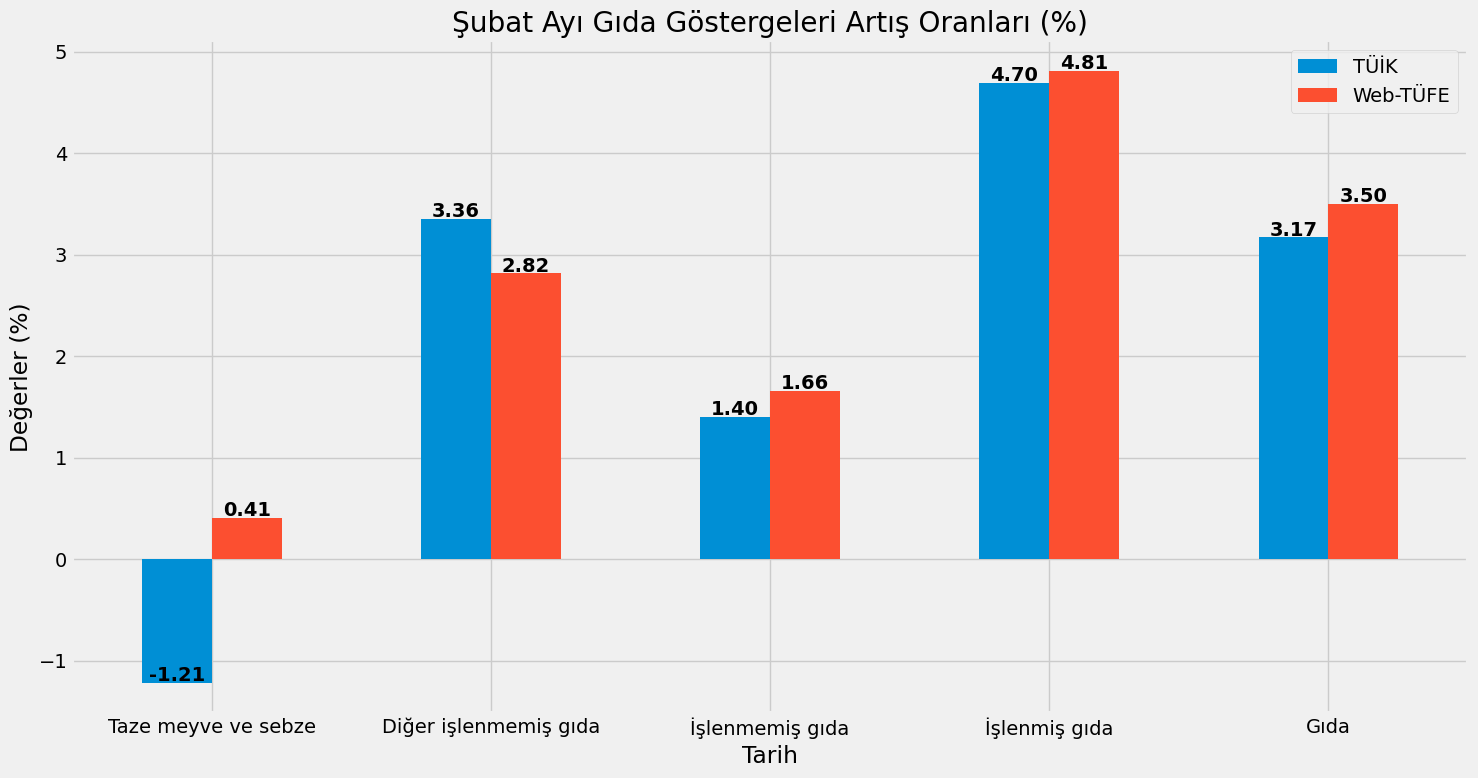

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("fivethirtyeight")
# Creating the data
data = {
    "TÜİK": tüik.pct_change().iloc[-1]*100,
    "Web-TÜFE": [0.41,2.82,1.66,4.81],

}

# Convert to DataFrame
df = pd.DataFrame(data)
df.loc["Gıda"]=[3.17,3.5]


# Plotting the bar chart with bold values on top of the bars
plt.figure(figsize=(15, 8))
ax = df.plot(kind='bar', figsize=(15, 8))

# Adding the values on top of the bars with bold text
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=14, fontweight='bold', color='black', xytext=(0, 5), textcoords='offset points')

plt.title("Şubat Ayı Gıda Göstergeleri Artış Oranları (%)")
plt.xlabel("Tarih")
plt.ylabel("Değerler (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [37]:
gıda=pd.read_excel("ozel kapsamli tufe gostergeleri (1).xls")
gıda=gıda.iloc[50:51,3:].T
gıda.columns=["Aylık Değişim"]
gıda=gıda.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(gıda)))
gıda=gıda.loc["2024-11-30":]
gıda["Tarih"]=gıda.index.strftime("%Y-%m")
gıda=gıda.reset_index(drop=True)
gıda_c=gıda[["Tarih","Aylık Değişim"]]


aylık_endeks_tüik=list(gıda_c["Aylık Değişim"])
tüik_aylık=[1]
tüik_aylık.extend(list(((np.array(aylık_endeks_tüik)/100))+1))
tüik_aylık=pd.DataFrame(tüik_aylık,columns=["TÜİK"])
tüik_aylık=np.cumprod(tüik_aylık)*100

tüik_aylık.index=pd.date_range(start="2024-10-31",freq="M",periods=len(tüik_aylık)).strftime("%Y-%m-%d")
tüik_aylık.index=pd.to_datetime(tüik_aylık.index)

C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\2351233369.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gıda=gıda.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(gıda)))
C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\2351233369.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tüik_aylık.index=pd.date_range(start="2024-10-31",freq="M",periods=len(tüik_aylık)).strftime("%Y-%m-%d")


In [39]:
gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)
gfe["TÜİK"]=tüik_aylık["TÜİK"]
gfe=gfe.fillna(method="ffill")
gfe=gfe.fillna(100)

C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\1037474672.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gfe=gfe.fillna(method="ffill")


In [ ]:
"""
    sa_data=pd.DataFrame()
    for col in tüik.columns:
        sa_data[f"{col} Aylık Ortalama"]=hareketli_aylik_ortalama(özelgöstergeler[col]).iloc[:,[-1,]]
        sa_data[f"{col} Aylık Ortalama"]=sa_data[f"{col} Aylık Ortalama"].fillna(method="ffill")
        sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end')
        sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')
        sa_data.loc["2024-10","Önceki"]=pd.NA
        sa_data[f"{col} Önceki Endeks"]=pd.NA
        sa_data.loc["2024-11-01":,f"{col} Önceki Endeks"]=sa_data.loc[sa_data["Önceki"].dropna(),f"{col} Aylık Ortalama"].values

    sa_datadegisim=pd.DataFrame(index=pd.to_datetime(sa_data.loc["2024-11":].index))
    for col in tüik.columns:
        sa_datadegisim[col]=((sa_data[f"{col} Aylık Ortalama"]/sa_data[f"{col} Önceki Endeks"]).dropna()).values
        sa_datadegisim[col]=sa_datadegisim[col].astype(float)
        sa_datadegisim.index=pd.to_datetime(sa_datadegisim.index)
    sa_datadegisim=sa_datadegisim.resample('M').last()   
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Taze meyve ve sebze")] = [1.082103253420332, 1.0378297012546769]
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Diğer işlenmemiş gıda")] = [1.0333601398698096, 1.014720660120335]



    for col in sa_datadegisim.columns:
        sa_datadegisim[f"{col} MA"]=pd.NA


        for row in sa_datadegisim.index:
                tüik_data=tüik[col].loc[:(row.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')]
                tüik_data.loc[pd.to_datetime((row.to_period('M')).to_timestamp(how='end').strftime('%Y-%m-%d'))]=tüik_data.iloc[-1]*sa_datadegisim[col].loc[row]
                from statsmodels.tsa.x13 import x13_arima_analysis


                np.random.seed(42)



                x13_path = r'C:\Users\Bora\Desktop\x13as'
                
                

                
                ayris = x13_arima_analysis(tüik_data, x12path=x13_path,outlier=False,log=False)
                sa_datadegisim[f"{col} MA"].loc[row]=ayris.seasadj.pct_change().iloc[-1]*100


    for col in tüik.columns:
        sa_datadegisim[f"{col} Faktör"]=((sa_datadegisim[f"{col} MA"]/100)+1)/sa_datadegisim[col]
        sa_datadegisim["Ay"]=sa_datadegisim.reset_index()["Tarih"].dt.month.values

    sa_datadegisim.columns=['Taze meyve ve sebze', 'Diğer işlenmemiş gıda',
    'SA Taze meyve ve sebze', 'SA Diğer işlenmemiş gıda',
    'Taze meyve ve sebze Faktör', 'Ay', 'Diğer işlenmemiş gıda Faktör']
    sa_datadegisim["İşlenmiş gıda"]=hareketli_aylik_ortalama(özelgöstergeler["İşlenmiş gıda"])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("İşlenmiş gıda")] = [2.61412286061347, 1.60328139006671]


    ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
    w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
    w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
    meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
    sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
    meyvesebze=np.concatenate([meyveler,sebzeler])
    digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

    islenmemis=digerislenmemis+list(meyvesebze)

    ağırlıklar=ağırlıklar.reset_index()
    meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
    meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
    digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
    digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
    islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
    islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()

    sa_datadegisim["SA İşlenmemiş gıda"]=(sa_datadegisim[islenmemisler.sort_index().index.unique()]*islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()).sum(axis=1)


    islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
    islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

    islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

    genel=pd.concat([islenmemisler,islenmisler],axis=0)

    sa_datadegisim["SA Web-GFE"]=(sa_datadegisim[genel.sort_index().groupby(level=0)["Ağırlık"].sum().index]*genel.groupby(level=0)["Ağırlık"].sum()).sum(axis=1)
    sa_datadegisim.to_csv("magöstergeler.csv")
"""

In [ ]:
göstergeaylık=pd.DataFrame()
for col in tüik.columns:
    göstergeaylık[col]=hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
    göstergeaylık[col].iloc[-1]=(((hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].iloc[-1]/hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].loc["2025-02-01"]))-1)*100

In [27]:
göstergeaylık


,Taze meyve ve sebze,Diğer işlenmemiş gıda,İşlenmemiş gıda,İşlenmiş gıda
Tarih,,,,
2024-11-30,5.477013,1.741840,3.612414,0.861357
2024-12-31,6.073420,3.877814,4.924704,2.034034
2025-01-31,6.135508,3.243180,4.713203,2.438807
2025-02-28,-0.040998,2.862252,1.335669,4.798631
2025-03-31,12.344673,3.698780,7.990578,2.912418


In [19]:
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()


C:\Users\Bora\AppData\Local\Temp\ipykernel_9800\2997715634.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))


Commit işlemi başarılı: update
Push işlemi başarılı.
